<a href="https://www.kaggle.com/code/saimmm/sa-bert?scriptVersionId=131910139" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Install Dependencies

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117


Looking in indexes: https://download.pytorch.org/whl/cu117


In [2]:
!pip install transformers requests beautifulsoup4 pandas numpy

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

# Instantiate Model 

In [4]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Encode and Calculate Sentiment

In [5]:
tokens = tokenizer.encode('I relayy hate this, not really cool', return_tensors='pt')

In [6]:
result = model(tokens)

In [7]:
int(torch.argmax(result.logits))+1

2

# Collect Reviews

In [8]:
r = requests.get('https://www.yelp.com/biz/social-brew-cafe-pyrmont') #grab from site
soup = BeautifulSoup(r.text, 'html.parser') 
regex = re.compile('.*comment.*') #Extract comments from a a class named comment
results = soup.find_all('p', {'class':regex})
reviews = [result.text for result in results]

In [9]:
results[0].text

"Great coffee and vibe. That's all \xa0you need. Crab was outstanding but not good finger food like a taco should be. Really want to try the pork belly sandwich - looked excellent. This became my go to breakfast place in Darling harbor. Had the avocado salmon salad breakfast and it was excellent. Service has been excellent."

# Load Reviews into DataFrame and Score

In [10]:
import pandas as pd
import numpy as np

In [11]:
df = pd.DataFrame(np.array(reviews), columns = ['review'])

In [12]:
df.head()

,review
0,Great coffee and vibe. That's all you need. C...
1,Great coffee and vibe. That's all you need. C...
2,Great food amazing coffee and tea. Short walk ...
3,It was ok. Had coffee with my friends. I'm new...
4,Ricotta hot cakes! These were so yummy. I ate ...


In [13]:
df['review'].iloc[7]

"We came for brunch twice in our week-long visit to Sydney. Everything on the menu not only sounds delicious, but is really tasty. It really gave us a sour taste of how bad breaky is in America with what's so readily available in Sydney! \xa0Both days we went were Saturdays and there was a bit of a wait to be seated, the cafe is extremely busy for both dine-in and take-away. Service is fairly quick and servers are all friendly. The location is in Surrey Hills a couple blocks away from the bustling touristy Darling Harbor.The green smoothie is very tasty and refreshing. We tried the smoked salmon salad, the soft shell crab tacos, ricotta hotcakes, and the breaky sandwich. All were delicious, well seasoned, and a solid amount of food for the price. A definite recommend for anyone's trip into Sydney!"

In [14]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [15]:
sentiment_score(df['review'].iloc[7])

5

In [16]:
df['sentiment'] = df['review'].apply(lambda x: sentiment_score(x[:512]))
#Limited to 512 tokens

In [17]:
df

,review,sentiment
0,Great coffee and vibe. That's all you need. C...,5
1,Great coffee and vibe. That's all you need. C...,4
2,Great food amazing coffee and tea. Short walk ...,5
3,It was ok. Had coffee with my friends. I'm new...,3
4,Ricotta hot cakes! These were so yummy. I ate ...,5
5,Great staff and food. Must try is the pan fri...,5
6,I came to Social brew cafe for brunch while ex...,5
7,We came for brunch twice in our week-long visi...,4
8,It was ok. The coffee wasn't the best but it w...,3
9,I went here a little while ago- a beautiful mo...,2


In [18]:
df['review'].iloc[3]

"It was ok. Had coffee with my friends. I'm new in the area, still need to discover new places."

# Visualization

In [19]:
!pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


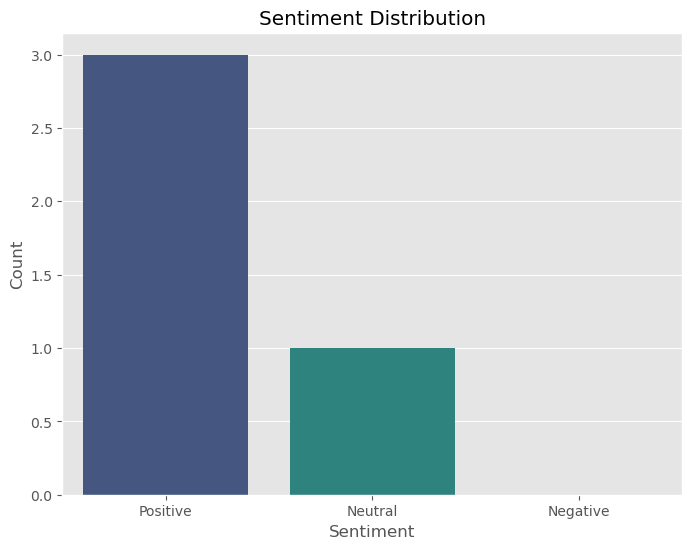

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# ... existing code ...

# Calculate sentiment scores
df['sentiment'] = df['review'].apply(lambda x: sentiment_score(x[:512]))

# Convert sentiment scores to labels
df['sentiment_label'] = df['sentiment'].map({1: 'Negative', 2: 'Neutral', 3: 'Positive'})

# Get sentiment counts
sentiment_counts = df['sentiment_label'].value_counts()

# Define sentiment labels in the correct order
sentiment_labels = ['Positive', 'Neutral', 'Negative']

# Sort sentiment counts and labels
sentiment_counts = sentiment_counts.reindex(sentiment_labels)

plt.figure(figsize=(8, 6))
plt.style.use('ggplot')  # Set the style to ggplot
sns.barplot(x=sentiment_labels, y=sentiment_counts, palette="viridis")
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

